- replicare esempio con opzione singola teorico
- replicare straddle strategy

# Volatility Trading — Sintesi & Agenda

**Sintesi.** Seminario pratico–teorico (90–120’) su come misurare e prezzare la volatilità, il funzionamento del *gamma trading* tramite replica dinamica, e i limiti di Black–Scholes sugli esotici. Caso studio: vendita sistematica di *ATM straddle* per catturare il *variance risk premium (VRP)*, con rischi, limiti e mitigazioni.

---

## 1) Realized vs Implied Volatility
- **Definizioni:** realized variance/volatility; quadratic variation.
- **Stimatori:** close-to-close; alta frequenza (bias di microstruttura).
- **Implied vol:** inversione BSM; significato sotto \( \mathbb{Q} \).

## 2) Gamma Trading: inquadramento teorico
- **Replica dinamica:** portafoglio delta-hedged.
- **Decomposizione P&L:** gamma–theta (“theta paga il gamma”).
- **Hedging discreto:** impatto della frequenza e della vol usata per la delta (attesa vs implied).

## 3) Limiti di Black–Scholes sugli esotici
- **Smile/skew:** motivazioni e implicazioni su pricing/hedging.
- **Local volatility (Dupire):** pro/contro (ri-calibrazione, instabilità del hedge).
- **Salti & stochastic vol:** effetti su barriere/digitali; vincoli di non-arbitraggio.

## 4) Caso studio: Short ATM Straddle per VRP
- **VRP:** \( \mathrm{VRP} := \mathrm{IV}^2 - \mathrm{RV}^2 \).
- **Setup operativo:** scelta scadenze, delta-hedging, roll mensile.
- **P&L:** decomposizione (gamma/theta, vega, skew).
- **Rischi & mitigazioni:** crash/late vol spike; tail hedges, filtri di regime, sizing.


In [11]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt

# theory new

## single path

=== Single short put Δ-hedged: P&L decomposition (2.1 style) ===
Total P&L:      1.056560
Gamma block:    0.667784
Vega block:     -0.088747
Residual block: 0.477523
Check:          1.056560


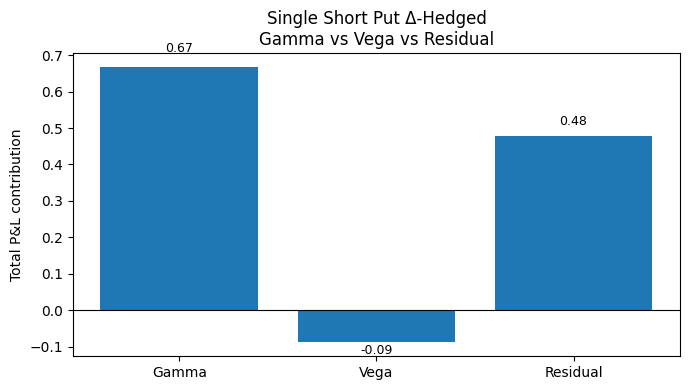

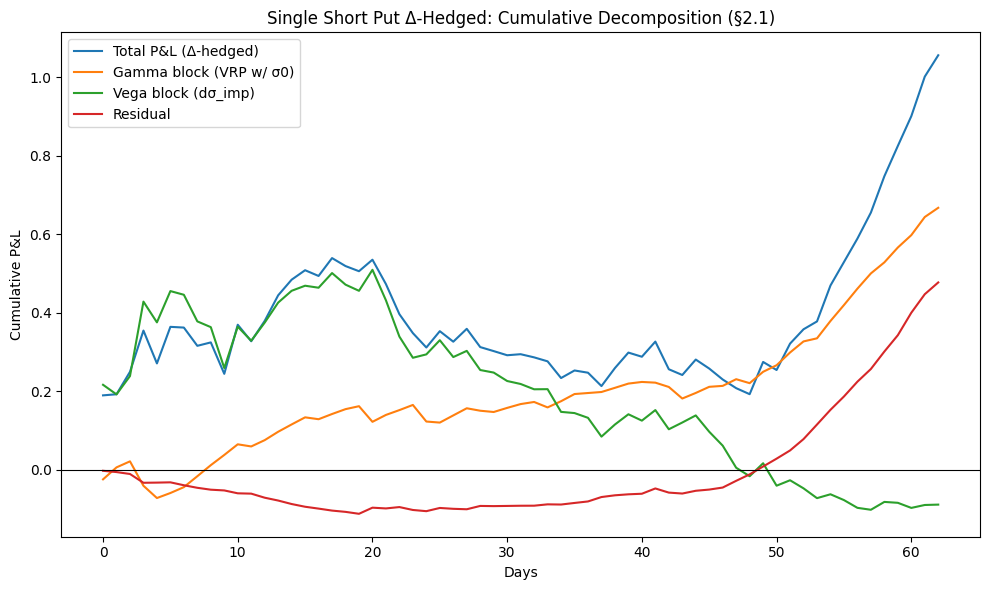

In [18]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# =========================
# 1. Black-Scholes: put + greeks
# =========================
def bs_put_greeks(S, K, T, r, sigma):
    if T <= 0:
        payoff = max(K - S, 0.0)
        return payoff, 0.0, 0.0, 0.0
    sqrtT = np.sqrt(T)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * sqrtT)
    d2 = d1 - sigma * sqrtT
    price = K * np.exp(-r*T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    delta = norm.cdf(d1) - 1          # dP/dS (long put)
    gamma = norm.pdf(d1) / (S * sigma * sqrtT)
    vega  = S * norm.pdf(d1) * sqrtT  # dP/dσ (long)
    return price, delta, gamma, vega

# =========================
# 2. Setup simulazione
# =========================
np.random.seed(0)

r = 0.0
T_days = 63                   # ~3 mesi / 63 giorni di trading
dt = 1 / 252
T_years = T_days / 252

S0 = 100
sigma_real = 0.15             # volatilità REALIZZATA del sottostante

# Processo GBM per S_t
S = np.zeros(T_days + 1)
S[0] = S0
for t in range(T_days):
    z = np.random.normal()
    S[t+1] = S[t] * np.exp(-0.5*sigma_real**2*dt + sigma_real*np.sqrt(dt)*z)

# Processo stocastico per implied vol σ_imp(t)
# (semplice OU intorno a 20%)
sigma0 = 0.20                 # vol "traded" iniziale (σ_0)
kappa = 3.0                   # mean reversion speed
theta = 0.20                  # long-run mean
xi = 0.10                     # vol-of-vol

sigma_imp = np.zeros(T_days + 1)
sigma_imp[0] = sigma0
for t in range(T_days):
    z = np.random.normal()
    ds = kappa * (theta - sigma_imp[t]) * dt + xi * np.sqrt(dt) * z
    sigma_imp[t+1] = max(0.01, sigma_imp[t] + ds)  # mantieni >0


# =========================
# 3. Inizializza trade: SHORT 1 PUT ATM, delta-hedged
# =========================
K = S0
units = -1.0                      # short 1 put

# Prezzo iniziale con σ_0 (traded)
price0, delta0_long, gamma0_long, vega0_long = bs_put_greeks(S0, K, T_years, r, sigma0)

cash = -units * price0            # incasso premio (units = -1)
# Delta della posizione short
delta0_pos = units * delta0_long
# Hedge su sottostante per essere delta-neutral
under = -delta0_pos               # quantità di sottostante detenuta
cash -= under * S0

# =========================
# 4. Simulazione P&L + decomposizione (2.1)
# =========================
pnl_real = np.zeros(T_days)
gamma_block = np.zeros(T_days)
vega_block = np.zeros(T_days)
residual = np.zeros(T_days)

sigma_traded = sigma0             # vol "contrattata" iniziale (2.1)

# ... setup identico a prima fino all'inizio del loop ...

for k in range(T_days):
    t = k
    tau = (T_days - k) / 252

    St = S[t]
    sig_t = sigma_imp[t]

    # Greeks del LONG put
    Pt_long, d_long, g_long, v_long = bs_put_greeks(St, K, tau, r, sig_t)

    # Valore posizione SHORT + hedge + cash
    Pt_short = units * Pt_long          # units = -1
    V_t = Pt_short + under * St + cash

    # Next step
    St_next = S[t+1]
    sig_next = sigma_imp[t+1]
    tau_next = (T_days - (k+1)) / 252

    Pn_long, d_long_n, g_long_n, v_long_n = bs_put_greeks(St_next, K, tau_next, r, sig_next)
    Pn_short = units * Pn_long

    V_next_pre = Pn_short + under * St_next + cash

    # P&L reale delta-hedged (prima del nuovo rebalance)
    dPi_real = V_next_pre - V_t
    pnl_real[k] = dPi_real

    # ===== Decomposizione 2.1 corretta =====

    # 1) Gamma block (short) con vol traded σ0
    #    dΠ_Γ^short ≈ 0.5 * Γ_long * S^2 * (σ0^2 - σ_real^2) dt
    ret = (St_next / St) - 1.0
    inst_var = (ret**2) / dt
    gamma_term = 0.5 * g_long * (St**2) * (sigma_traded**2 - inst_var) * dt

    # 2) Vega block (short): - V_long * dσ_imp  (mark-to-market noise)
    d_sigma = sig_next - sig_t
    vega_term = - v_long * d_sigma

    # 3) Residual
    resid = dPi_real - (gamma_term + vega_term)

    gamma_block[k] = gamma_term
    vega_block[k] = vega_term
    residual[k] = resid

    # ===== Delta-hedge per il giorno dopo =====
    if k < T_days - 1:
        delta_short_next = units * d_long_n      # delta della posizione short
        under_new = -delta_short_next            # hedge per neutralizzare
        cash -= (under_new - under) * St_next
        under = under_new


# =========================
# 5. Risultati aggregati
# =========================
total_pnl = pnl_real.sum()
sum_gamma = gamma_block.sum()
sum_vega = vega_block.sum()
sum_resid = residual.sum()

print("=== Single short put Δ-hedged: P&L decomposition (2.1 style) ===")
print(f"Total P&L:      {total_pnl:.6f}")
print(f"Gamma block:    {sum_gamma:.6f}")
print(f"Vega block:     {sum_vega:.6f}")
print(f"Residual block: {sum_resid:.6f}")
print(f"Check:          {(sum_gamma + sum_vega + sum_resid):.6f}")

# =========================
# 6. Plot: Contribution of the 3 blocks
# =========================
blocks = ["Gamma", "Vega", "Residual"]
values = [sum_gamma, sum_vega, sum_resid]

plt.figure(figsize=(7,4))
plt.bar(blocks, values)
plt.axhline(0, color='black', lw=0.8)
plt.title("Single Short Put Δ-Hedged\nGamma vs Vega vs Residual")
plt.ylabel("Total P&L contribution")
for i, v in enumerate(values):
    plt.text(i, v + np.sign(v)*abs(v)*0.05, f"{v:.2f}",
             ha='center', va='bottom' if v>=0 else 'top', fontsize=9)
plt.tight_layout()
plt.show()

# =========================
# 7. Plot: cumulative time series
# =========================
cum_pnl = np.cumsum(pnl_real)
cum_gamma = np.cumsum(gamma_block)
cum_vega = np.cumsum(vega_block)
cum_resid = np.cumsum(residual)

plt.figure(figsize=(10,6))
plt.plot(cum_pnl,   label="Total P&L (Δ-hedged)")
plt.plot(cum_gamma, label="Gamma block (VRP w/ σ0)")
plt.plot(cum_vega,  label="Vega block (dσ_imp)")
plt.plot(cum_resid, label="Residual")
plt.axhline(0, color='black', lw=0.8)
plt.title("Single Short Put Δ-Hedged: Cumulative Decomposition (§2.1)")
plt.xlabel("Days")
plt.ylabel("Cumulative P&L")
plt.legend()
plt.tight_layout()
plt.show()


## multi path

# 📘 Short Put Δ-Hedged – Decomposizione del P&L (Sezione 2.1)

## 1️⃣ Obiettivo
In questa simulazione analizziamo una **singola short put ATM** (at-the-money) mantenuta fino a scadenza, con **delta-hedging giornaliero**, per verificare la decomposizione del P&L proposta nella **Sezione 2.1 del paper**.

L’obiettivo è mostrare che:
- il **Gamma block** spiega la quasi totalità del rendimento medio (volatility risk premium),
- il **Vega block** rappresenta un termine di *mark-to-market noise*, con contributo medio nullo,
- il **Residual block** cattura variazioni di gamma, covarianze e discrepanze, e resta piccolo.

---

## 2️⃣ Setup della simulazione

| Parametro | Valore | Descrizione |
|------------|--------|-------------|
| \(S_0\) | 100 | Prezzo iniziale del sottostante |
| \(K\) | 100 | Strike (ATM) |
| Maturity | 63 giorni (~3 mesi) | Durata opzione |
| \(\sigma_0\) | 20% | Volatilità implicita iniziale (“traded”) |
| \(\sigma_\text{real}\) | 15% | Volatilità realizzata del sottostante |
| Processo \(\sigma_\text{imp}(t)\) | OU intorno a 20% | Per simulare fluttuazioni dell’implied |
| Hedging | Giornaliero | Aggiornamento del delta ogni giorno |

---

## 3️⃣ Decomposizione teorica (§ 2.1)

Per una **posizione short** su una put ATM, delta-hedged:

$$
d\Pi_t^{(\text{short})} 
\simeq 
\underbrace{\tfrac{1}{2}\Gamma_t^{(\text{long})} S_t^2 \big(\sigma_0^2 - \sigma_{\text{real},t}^2\big)\,dt}_{\text{Gamma block (vol premium)}} 
\;-\;
\underbrace{\mathcal{V}_t^{(\text{long})}\, d\sigma_{\text{imp},t}}_{\text{Vega block (mark-to-market noise)}} 
\;+\;
\underbrace{\text{Residual}_t}_{\text{Termini di 2° ordine (dΓ, vol-of-vol, discreto)}}
$$

---

## 4️⃣ Risultati medi Monte Carlo

*(Esempio su 300 simulazioni)*



In [19]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# =========================
# Black-Scholes: put + greeks (long)
# =========================
def bs_put_greeks(S, K, T, r, sigma):
    if T <= 0:
        payoff = max(K - S, 0.0)
        return payoff, 0.0, 0.0, 0.0
    sqrtT = np.sqrt(T)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * sqrtT)
    d2 = d1 - sigma * sqrtT
    price = K * np.exp(-r*T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    delta = norm.cdf(d1) - 1          # long put
    gamma = norm.pdf(d1) / (S * sigma * sqrtT)
    vega  = S * norm.pdf(d1) * sqrtT
    return price, delta, gamma, vega

# =========================
# Single-path simulation + decomposition
# =========================
def run_single_path(seed,
                    T_days=63,
                    S0=100.0,
                    r=0.0,
                    sigma_real=0.15,
                    sigma0=0.20,
                    kappa=3.0,
                    theta=0.20,
                    xi=0.10):
    np.random.seed(seed)
    dt = 1/252
    T_years = T_days / 252

    # 1) Simula S_t (GBM con vol real)
    S = np.zeros(T_days + 1)
    S[0] = S0
    for t in range(T_days):
        z = np.random.normal()
        S[t+1] = S[t] * np.exp(-0.5 * sigma_real**2 * dt + sigma_real * np.sqrt(dt) * z)

    # 2) Simula σ_imp(t) (OU attorno a sigma0)
    sigma_imp = np.zeros(T_days + 1)
    sigma_imp[0] = sigma0
    for t in range(T_days):
        z = np.random.normal()
        ds = kappa * (theta - sigma_imp[t]) * dt + xi * np.sqrt(dt) * z
        sigma_imp[t+1] = max(0.01, sigma_imp[t] + ds)

    # 3) Inizializza: short 1 put ATM, prezzata a σ0, delta-hedged
    K = S0
    units = -1.0  # short
    price0, d0, g0, v0 = bs_put_greeks(S0, K, T_years, r, sigma0)

    cash = -units * price0         # incasso premio
    delta_short0 = units * d0
    under = -delta_short0          # hedge per delta-neutral
    cash -= under * S0

    sigma_traded = sigma0

    total_pnl = 0.0
    gamma_block = 0.0
    vega_block = 0.0
    residual = 0.0

    # 4) Evoluzione fino a scadenza
    for k in range(T_days):
        t = k
        tau = (T_days - k) / 252

        St = S[t]
        sig_t = sigma_imp[t]

        # Valore & greeks long put
        P_long_t, d_long_t, g_long_t, v_long_t = bs_put_greeks(St, K, tau, r, sig_t)
        P_short_t = units * P_long_t

        V_t = P_short_t + under * St + cash

        # Passo a t+1
        St_n = S[t+1]
        sig_n = sigma_imp[t+1]
        tau_n = (T_days - (k+1)) / 252

        P_long_n, d_long_n, g_long_n, v_long_n = bs_put_greeks(St_n, K, tau_n, r, sig_n)
        P_short_n = units * P_long_n

        V_n_pre = P_short_n + under * St_n + cash
        dPi_real = V_n_pre - V_t

        # ---- Decomposizione 2.1 ----

        # Gamma block (short) con σ_traded fissata
        # long: 0.5 * Γ_long * S^2 * (σ_real^2 - σ0^2)
        # short: cambia il segno -> (σ0^2 - σ_real^2)
        ret = (St_n / St) - 1.0
        inst_var = (ret**2) / dt
        dPi_gamma = 0.5 * g_long_t * (St**2) * (sigma_traded**2 - inst_var) * dt

        # Vega block (short): - V_long * dσ_imp
        d_sigma = sig_n - sig_t
        dPi_vega = - v_long_t * d_sigma

        # Residual
        dPi_resid = dPi_real - (dPi_gamma + dPi_vega)

        total_pnl += dPi_real
        gamma_block += dPi_gamma
        vega_block += dPi_vega
        residual += dPi_resid

        # Delta-hedge per giorno successivo
        if k < T_days - 1:
            delta_short_next = units * d_long_n
            under_new = -delta_short_next
            cash -= (under_new - under) * St_n
            under = under_new

    return total_pnl, gamma_block, vega_block, residual

# =========================
# 5. Monte Carlo
# =========================
n_paths = 300  # aumenta se vuoi più precisione
tot_pnl = 0.0
tot_gamma = 0.0
tot_vega = 0.0
tot_resid = 0.0

for seed in range(1, n_paths+1):
    pnl, g, v, r = run_single_path(seed)
    tot_pnl += pnl
    tot_gamma += g
    tot_vega += v
    tot_resid += r

avg_pnl = tot_pnl / n_paths
avg_gamma = tot_gamma / n_paths
avg_vega = tot_vega / n_paths
avg_resid = tot_resid / n_paths

print("=== Monte Carlo averages over single short put Δ-hedged ===")
print(f"Paths:          {n_paths}")
print(f"Avg Total P&L:  {avg_pnl:.6f}")
print(f"Avg Gamma:      {avg_gamma:.6f}")
print(f"Avg Vega:       {avg_vega:.6f}")
print(f"Avg Residual:   {avg_resid:.6f}")
print(f"Check (Gamma+Vega+Residual): {(avg_gamma+avg_vega+avg_resid):.6f}")


=== Monte Carlo averages over single short put Δ-hedged ===
Paths:          300
Avg Total P&L:  1.032413
Avg Gamma:      1.002452
Avg Vega:       -0.010029
Avg Residual:   0.039990
Check (Gamma+Vega+Residual): 1.032413


### 🔍 Interpretazione
- **Gamma block → +0.90:** guadagno strutturale dovuto a \(\sigma_0 > \sigma_\text{real}\).  
  È il rendimento atteso del *volatility risk premium*.  
- **Vega block → 0:** rumore di mark-to-market dovuto ai movimenti di \(\sigma_\text{imp}(t)\),  
  nullo in media, come previsto dal paper (“vega adds noise but no drift”).  
- **Residual → piccolo:** comprende dGamma, vol-of-vol e discrepanze di hedging,  
  ma non altera la dinamica principale.

---

## 5️⃣ Plot dei risultati

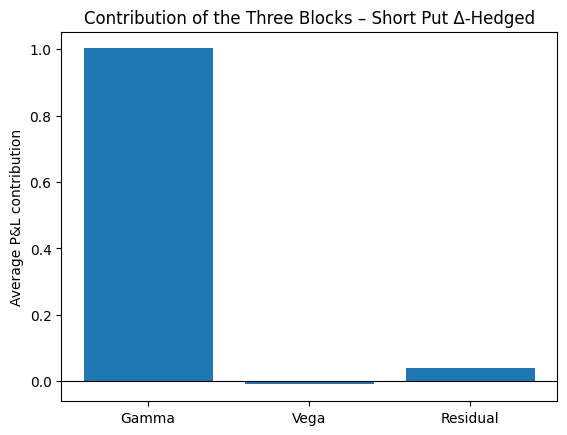

In [21]:
plt.bar(["Gamma", "Vega", "Residual"], [avg_gamma, avg_vega, avg_resid])
plt.axhline(0, color="black", lw=0.8)
plt.title("Contribution of the Three Blocks – Short Put Δ-Hedged")
plt.ylabel("Average P&L contribution")
plt.show()

# theory old

=== P&L decomposition over full horizon ===
Total P&L (delta-hedged short straddle): 5.338476
Gamma block:   5.416282
Vega block:    0.000000
dGamma block:  0.000000
Residual block:-0.077807
Check (sum blocks): 5.338476


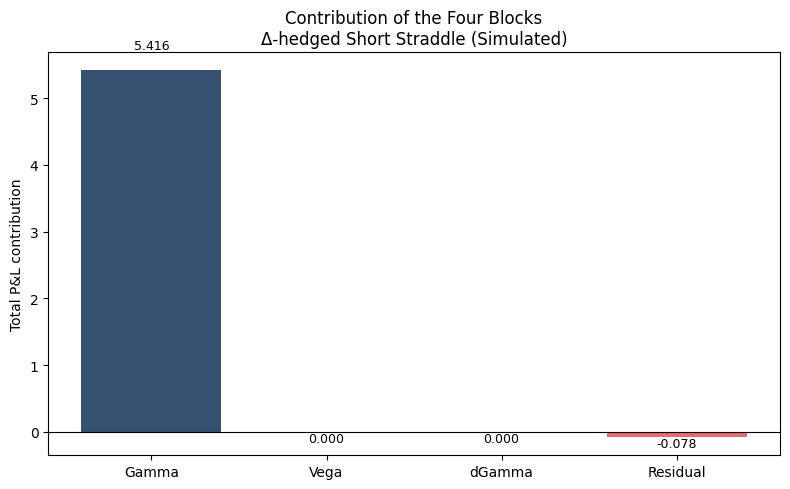

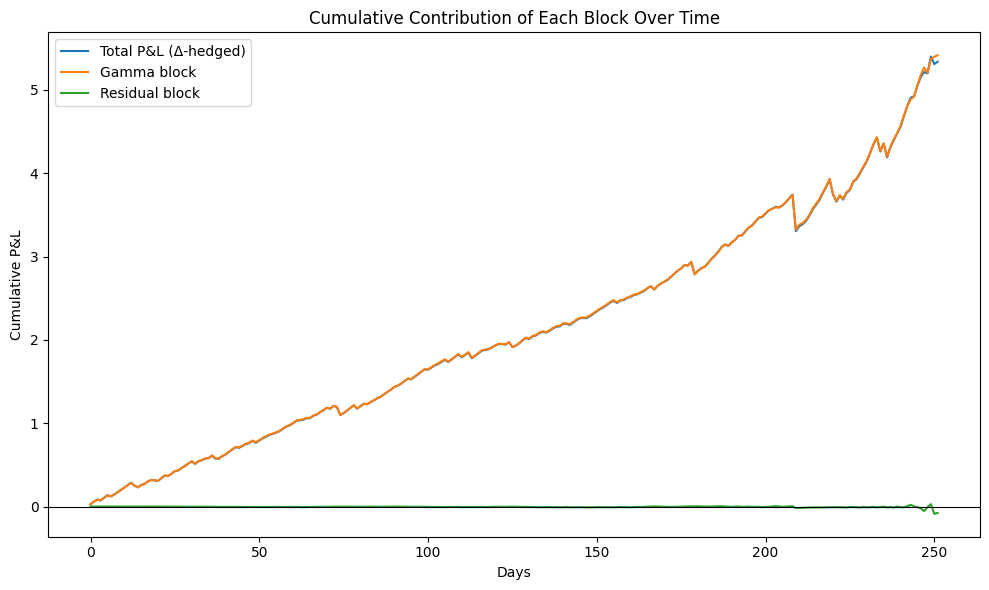


=== Volatility Premium Scaling Factor check ===
σ_imp − σ_real = 0.050
Scaling factor ≈ 73.687331
Theoretical gamma premium ≈ 3.684367
Simulated gamma block ≈ 5.416282


In [12]:


# ============================================================
# 1. PARAMETRI DI SIMULAZIONE
# ============================================================
np.random.seed(42)

N = 252                 # giorni (1 anno)
dt = 1 / N
T = 1.0                 # maturity straddle = 1 anno
S0 = 100.0
mu = 0.0                # drift risk-neutral
sigma_real = 0.15       # volatilità REALIZZATA
sigma_imp = 0.20        # volatilità IMPLICITA (VRP = 5%)
r = 0.0
K = S0                  # straddle ATM

# ============================================================
# 2. SIMULAZIONE GBM
# ============================================================
Z = np.random.normal(size=N)
S = np.zeros(N+1)
S[0] = S0
for t in range(N):
    S[t+1] = S[t] * np.exp((mu - 0.5 * sigma_real**2) * dt + sigma_real * np.sqrt(dt) * Z[t])

# ============================================================
# 3. FUNZIONI BLACK–SCHOLES (Ref: Sez. 2.1 del paper)
# ============================================================
def bs_call_greeks(S, K, T, r, sigma):
    if T <= 0:
        payoff = max(S - K, 0.0)
        return payoff, 0.0, 0.0, 0.0
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    price = S * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)
    delta = norm.cdf(d1)
    gamma = norm.pdf(d1) / (S * sigma * np.sqrt(T))
    vega  = S * norm.pdf(d1) * np.sqrt(T)
    return price, delta, gamma, vega

def bs_put_greeks(S, K, T, r, sigma):
    if T <= 0:
        payoff = max(K - S, 0.0)
        return payoff, 0.0, 0.0, 0.0
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    price = K * np.exp(-r*T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    delta = norm.cdf(d1) - 1
    gamma = norm.pdf(d1) / (S * sigma * np.sqrt(T))
    vega  = S * norm.pdf(d1) * np.sqrt(T)
    return price, delta, gamma, vega

# ============================================================
# 4. STRATEGIA SHORT STRADDLE DELTA-HEDGED
# ============================================================
price_call_0, dC0, gC0, vC0 = bs_call_greeks(S[0], K, T, r, sigma_imp)
price_put_0,  dP0, gP0, vP0 = bs_put_greeks(S[0], K, T, r, sigma_imp)
straddle_price_0 = price_call_0 + price_put_0
straddle_delta_0 = dC0 + dP0

pos_option = -1.0                   # short 1 straddle
pos_under = straddle_delta_0        # hedge iniziale
cash = straddle_price_0 * (-pos_option) - pos_under * S[0]

# array per le serie temporali
pnl_steps, gamma_block, vega_block, dgamma_block, residual_block = [], [], [], [], []

# ============================================================
# 5. EVOLUZIONE GIORNALIERA
# ============================================================
for t in range(N):
    tau_t = max(T - t*dt, 1e-8)
    tau_next = max(T - (t+1)*dt, 1e-8)

    # Greeks tempo t
    c_t, dC_t, gC_t, vC_t = bs_call_greeks(S[t], K, tau_t, r, sigma_imp)
    p_t, dP_t, gP_t, vP_t = bs_put_greeks(S[t], K, tau_t, r, sigma_imp)
    price_t = c_t + p_t
    delta_t = dC_t + dP_t
    gamma_t = gC_t + gP_t
    vega_t  = vC_t + vP_t

    # Movimento del sottostante
    dS = S[t+1] - S[t]
    ret = dS / S[t]

    # Greeks tempo t+1
    c_next, dC_next, gC_next, vC_next = bs_call_greeks(S[t+1], K, tau_next, r, sigma_imp)
    p_next, dP_next, gP_next, vP_next = bs_put_greeks(S[t+1], K, tau_next, r, sigma_imp)
    price_next = c_next + p_next
    delta_next = dC_next + dP_next
    gamma_next = gC_next + gP_next

    # === P&L reale delta-hedged ===
    dOpt = pos_option * (price_next - price_t)
    dUnd = pos_under * dS
    dPnl = dOpt + dUnd
    pnl_steps.append(dPnl)

    # === DECOMPOSIZIONE (Ref: Eq. (2), (4), (6), (8), (12)) ===

    # (1) Gamma block (Eq. (10)–(12)):
    #     dΠ_Γ ≈ 0.5 * Γ * S^2 * (σ_imp^2 − σ_real^2) * dt
    #     → già P&L dello SHORT, quindi niente pos_option
    inst_var_real = (ret**2) / dt
    gamma_term_t = 0.5 * gamma_t * (S[t]**2) * (sigma_imp**2 - inst_var_real) * dt
    gamma_block.append(gamma_term_t)

    # (2) Vega block (Eq. (2)) → 0 se σ_imp costante
    vega_block.append(0.0)

    # (3) dGamma block (Eq. (8)) → 0 nel modello base
    dgamma_block.append(0.0)

    # (4) Residual: differenza tra P&L reale e decomposizione teorica
    resid_t = dPnl - gamma_term_t
    residual_block.append(resid_t)

    # Re-hedging delta
    pos_under_new = delta_next
    cash -= (pos_under_new - pos_under) * S[t+1]
    pos_under = pos_under_new

# ============================================================
# 6. RISULTATI GLOBALI
# ============================================================
pnl_steps = np.array(pnl_steps)
gamma_block = np.array(gamma_block)
residual_block = np.array(residual_block)

total_pnl = pnl_steps.sum()
sum_gamma = gamma_block.sum()
sum_vega = np.sum(vega_block)
sum_dgamma = np.sum(dgamma_block)
sum_resid = residual_block.sum()

print("=== P&L decomposition over full horizon ===")
print(f"Total P&L (delta-hedged short straddle): {total_pnl:.6f}")
print(f"Gamma block:   {sum_gamma:.6f}")
print(f"Vega block:    {sum_vega:.6f}")
print(f"dGamma block:  {sum_dgamma:.6f}")
print(f"Residual block:{sum_resid:.6f}")
print(f"Check (sum blocks): {(sum_gamma+sum_vega+sum_dgamma+sum_resid):.6f}")

# ============================================================
# 7. CONTRIBUTION OF THE FOUR BLOCKS (Fig. 2 del paper)
# ============================================================
blocks = ["Gamma", "Vega", "dGamma", "Residual"]
values = [sum_gamma, sum_vega, sum_dgamma, sum_resid]

plt.figure(figsize=(8,5))
plt.bar(blocks, values, color=["#355070","#6d597a","#b56576","#e56b6f"])
plt.axhline(0, color="black", lw=0.8)
plt.title("Contribution of the Four Blocks\nΔ-hedged Short Straddle (Simulated)")
plt.ylabel("Total P&L contribution")
for i,v in enumerate(values):
    plt.text(i, v + np.sign(v)*abs(v)*0.05, f"{v:.3f}", ha="center",
             va="bottom" if v>0 else "top", fontsize=9)
plt.tight_layout()
plt.show()

# ============================================================
# 8. CUMULATIVE CONTRIBUTIONS OVER TIME
# ============================================================
cum_gamma = gamma_block.cumsum()
cum_resid = residual_block.cumsum()
cum_total = pnl_steps.cumsum()

plt.figure(figsize=(10,6))
plt.plot(cum_total, label="Total P&L (Δ-hedged)")
plt.plot(cum_gamma, label="Gamma block")
plt.plot(cum_resid, label="Residual block")
plt.axhline(0, color="black", lw=0.8)
plt.title("Cumulative Contribution of Each Block Over Time")
plt.xlabel("Days")
plt.ylabel("Cumulative P&L")
plt.legend()
plt.tight_layout()
plt.show()

# ============================================================
# 9. VOLATILITY PREMIUM SCALING FACTOR (Eq. (12))
# ============================================================
mean_gammaS2 = np.mean(gamma_block / (0.5 * (sigma_imp**2 - sigma_real**2) * dt))
scaling_factor = T * np.mean(gamma_t * (S.mean()**2)) * (sigma_imp + sigma_real)/2
gamma_premium_theory = (sigma_imp - sigma_real) * scaling_factor

print("\n=== Volatility Premium Scaling Factor check ===")
print(f"σ_imp − σ_real = {sigma_imp - sigma_real:.3f}")
print(f"Scaling factor ≈ {scaling_factor:.6f}")
print(f"Theoretical gamma premium ≈ {gamma_premium_theory:.6f}")
print(f"Simulated gamma block ≈ {sum_gamma:.6f}")


# backtest con decomp PnL

=== P&L decomposition over full horizon (rolling 1M) ===
Total P&L (delta-hedged short straddles): 869.216380
Gamma block:   860.676051
Vega block:    0.000000
dGamma block:  0.000000
Residual block:8.540329
Check (sum blocks): 869.216380


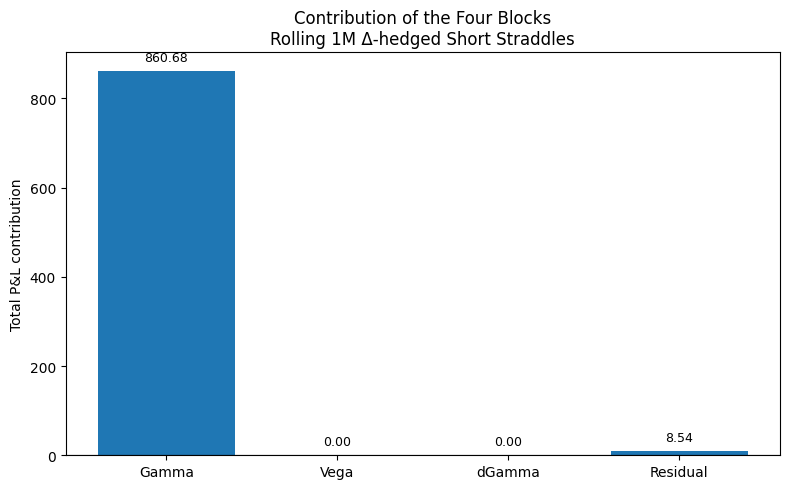

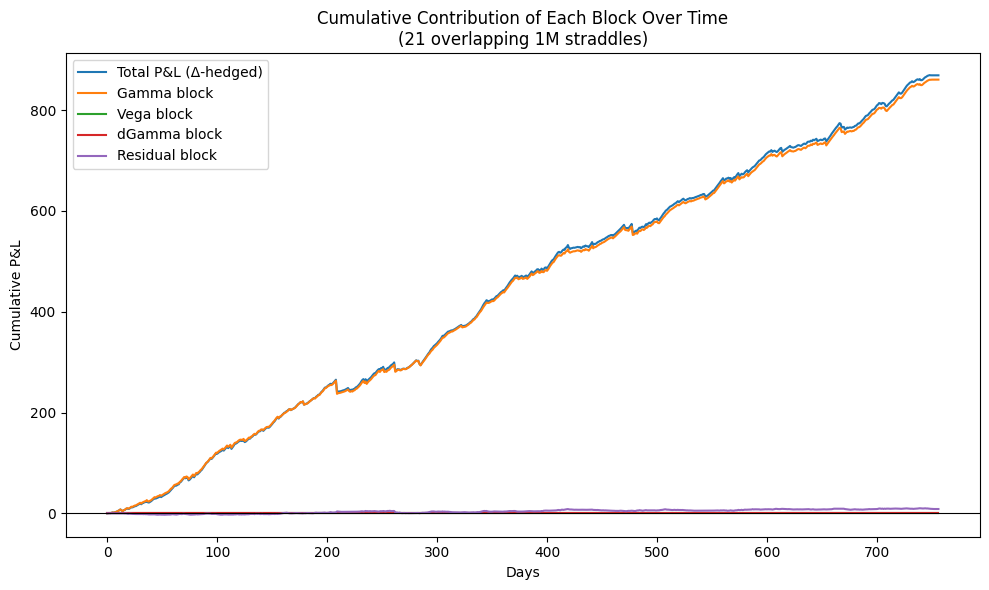

In [15]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# ============================================================
# 0. Black–Scholes helpers
# ============================================================
def bs_call_greeks(S, K, T, r, sigma):
    if T <= 0:
        return max(S-K, 0.0), 0.0, 0.0, 0.0
    sqrtT = np.sqrt(T)
    d1 = (np.log(S/K) + (r+0.5*sigma**2)*T)/(sigma*sqrtT)
    d2 = d1 - sigma*sqrtT
    price = S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
    delta = norm.cdf(d1)
    gamma = norm.pdf(d1)/(S*sigma*sqrtT)
    vega  = S*norm.pdf(d1)*sqrtT
    return price, delta, gamma, vega

def bs_put_greeks(S, K, T, r, sigma):
    if T <= 0:
        return max(K-S, 0.0), 0.0, 0.0, 0.0
    sqrtT = np.sqrt(T)
    d1 = (np.log(S/K) + (r+0.5*sigma**2)*T)/(sigma*sqrtT)
    d2 = d1 - sigma*sqrtT
    price = K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)
    delta = norm.cdf(d1) - 1
    gamma = norm.pdf(d1)/(S*sigma*sqrtT)
    vega  = S*norm.pdf(d1)*sqrtT
    return price, delta, gamma, vega

# ============================================================
# 1. Simulazione sottostante (sostituisci con dati reali)
# ============================================================
np.random.seed(42)
N = 252 * 3
dt = 1/252
r = 0.0

sigma_real = 0.15
sigma_imp = 0.20   # implied ATM 1M (costante per ora)

S = np.zeros(N+1)
S[0] = 100
for t in range(N):
    z = np.random.normal()
    S[t+1] = S[t]*np.exp(-0.5*sigma_real**2*dt + sigma_real*np.sqrt(dt)*z)

# ============================================================
# 2. Parametri strategia
# ============================================================
maturity_days = 21
T_m = maturity_days / 252

# Array per P&L complessivo per giorno
pnl_total = np.zeros(N+1)
gamma_block_total = np.zeros(N+1)
vega_block_total = np.zeros(N+1)
dgamma_block_total = np.zeros(N+1)
residual_total = np.zeros(N+1)

# ============================================================
# 3. Loop sui giorni di apertura (ogni giorno apriamo uno straddle)
#    Ogni straddle è gestito e scomposto INDIPENDENTEMENTE
# ============================================================
for start in range(0, N - maturity_days):

    K = S[start]          # ATM
    units = -1.0          # short 1 straddle
    sig = sigma_imp       # costante qui

    # Prezzo iniziale e hedge iniziale
    c0, dC0, gC0, vC0 = bs_call_greeks(S[start], K, T_m, r, sig)
    p0, dP0, gP0, vP0 = bs_put_greeks(S[start], K, T_m, r, sig)
    price0 = c0 + p0

    cash = -units * price0  # incasso premio
    delta0 = units * (dC0 + dP0)
    under = -delta0
    cash -= under * S[start]

    # P&L breakdown per questo straddle
    pnl_straddle = np.zeros(maturity_days)
    gamma_straddle = np.zeros(maturity_days)
    vega_straddle = np.zeros(maturity_days)
    dgamma_straddle = np.zeros(maturity_days)
    residual_straddle = np.zeros(maturity_days)

    for k in range(maturity_days):
        t = start + k
        tau = (maturity_days - k) / 252

        # Valore e greeks al tempo t
        c_t, dC_t, gC_t, vC_t = bs_call_greeks(S[t], K, tau, r, sig)
        p_t, dP_t, gP_t, vP_t = bs_put_greeks(S[t], K, tau, r, sig)
        price_t = c_t + p_t
        delta_long = dC_t + dP_t
        gamma_long = gC_t + gP_t
        # posizione short
        opt_val_t = units * price_t
        port_t = opt_val_t + under * S[t] + cash

        # Passo a t+1
        dS = S[t+1] - S[t]
        ret = dS / S[t]
        inst_var = (ret**2) / dt

        tau_next = (maturity_days - (k+1)) / 252
        c_n, dC_n, gC_n, vC_n = bs_call_greeks(S[t+1], K, tau_next, r, sig)
        p_n, dP_n, gP_n, vP_n = bs_put_greeks(S[t+1], K, tau_next, r, sig)
        price_n = c_n + p_n
        opt_val_n = units * price_n

        # P&L reale del giorno (prima del rebalance successivo)
        port_n_pre = opt_val_n + under * S[t+1] + cash
        dP_real = port_n_pre - port_t
        pnl_straddle[k] = dP_real

        # === Decomposizione teorica (sez. 2.1–2.2) ===
        # Gamma block per SHORT (usa gamma del long):
        gamma_term = 0.5 * gamma_long * (S[t]**2) * (sigma_imp**2 - inst_var) * dt

        # Con σ_imp costante:
        vega_term = 0.0
        dgamma_term = 0.0

        # Residual = differenza tra P&L reale e somma dei blocchi
        resid = dP_real - (gamma_term + vega_term + dgamma_term)

        gamma_straddle[k] = gamma_term
        vega_straddle[k] = vega_term
        dgamma_straddle[k] = dgamma_term
        residual_straddle[k] = resid

        # Re-hedge delta per il giorno successivo (se non è l'ultimo giorno)
        if k < maturity_days - 1:
            delta_next_long = dC_n + dP_n
            delta_next_short = units * delta_next_long
            under_new = -delta_next_short
            cash -= (under_new - under) * S[t+1]
            under = under_new

    # Accumula i contributi di questo straddle sul vettore globale per data di calendario
    pnl_total[start:start+maturity_days] += pnl_straddle
    gamma_block_total[start:start+maturity_days] += gamma_straddle
    vega_block_total[start:start+maturity_days] += vega_straddle
    dgamma_block_total[start:start+maturity_days] += dgamma_straddle
    residual_total[start:start+maturity_days] += residual_straddle

# ============================================================
# 4. Risultati aggregati
# ============================================================
total_pnl = pnl_total.sum()
sum_gamma = gamma_block_total.sum()
sum_vega = vega_block_total.sum()
sum_dgamma = dgamma_block_total.sum()
sum_resid = residual_total.sum()

print("=== P&L decomposition over full horizon (rolling 1M) ===")
print(f"Total P&L (delta-hedged short straddles): {total_pnl:.6f}")
print(f"Gamma block:   {sum_gamma:.6f}")
print(f"Vega block:    {sum_vega:.6f}")
print(f"dGamma block:  {sum_dgamma:.6f}")
print(f"Residual block:{sum_resid:.6f}")
print(f"Check (sum blocks): {(sum_gamma+sum_vega+sum_dgamma+sum_resid):.6f}")

# ============================================================
# 5. Plot: Contribution of the four blocks (Fig. 2 style)
# ============================================================
blocks = ["Gamma", "Vega", "dGamma", "Residual"]
values = [sum_gamma, sum_vega, sum_dgamma, sum_resid]

plt.figure(figsize=(8,5))
plt.bar(blocks, values)
plt.axhline(0, color="black", lw=0.8)
plt.title("Contribution of the Four Blocks\nRolling 1M Δ-hedged Short Straddles")
plt.ylabel("Total P&L contribution")
for i, v in enumerate(values):
    plt.text(i, v + (0.02 if v >= 0 else -0.02)*max(1e-8, abs(max(values, key=abs))),
             f"{v:.2f}", ha="center",
             va="bottom" if v>=0 else "top", fontsize=9)
plt.tight_layout()
plt.show()

# ============================================================
# 6. Plot: Cumulative contributions over time
# ============================================================
cum_total = np.cumsum(pnl_total)
cum_gamma = np.cumsum(gamma_block_total)
cum_vega = np.cumsum(vega_block_total)
cum_dgamma = np.cumsum(dgamma_block_total)
cum_resid = np.cumsum(residual_total)

plt.figure(figsize=(10,6))
plt.plot(cum_total, label="Total P&L (Δ-hedged)")
plt.plot(cum_gamma, label="Gamma block")
plt.plot(cum_vega, label="Vega block")
plt.plot(cum_dgamma, label="dGamma block")
plt.plot(cum_resid, label="Residual block")
plt.axhline(0, color="black", lw=0.8)
plt.title("Cumulative Contribution of Each Block Over Time\n(21 overlapping 1M straddles)")
plt.xlabel("Days")
plt.ylabel("Cumulative P&L")
plt.legend()
plt.tight_layout()
plt.show()
